In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array

from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)



In [8]:
best_lr = 0.001
best_inner_size = 1000
best_drop = 0.8

In [4]:
train_path = '/content/drive/MyDrive/AI_and_python/ML-Zoomcamp/data/CIFAKE/train'
test_path = '/content/drive/MyDrive/AI_and_python/ML-Zoomcamp/data/CIFAKE/test'

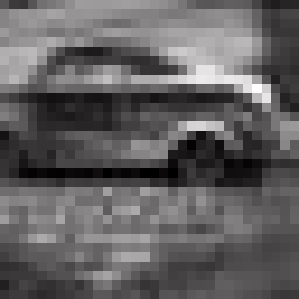

In [ ]:
fake_image_path = '/content/drive/MyDrive/AI_and_python/ML-Zoomcamp/data/CIFAKE/test/FAKE'
name = '0 (2).jpg'
fullname = f'{fake_image_path}/{name}'
image = load_img(fullname, target_size=(299, 299))
image

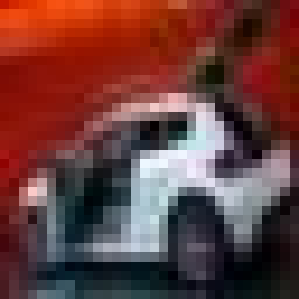

In [ ]:
real_image_path = '/content/drive/MyDrive/AI_and_python/ML-Zoomcamp/data/CIFAKE/test/REAL'
name = '0000 (2).jpg'
fullname = f'{real_image_path}/{name}'
image = load_img(fullname, target_size=(299, 299))
image

In [ ]:
x = np.array(image)


In [ ]:
X = np.array([x])
X.shape

(1, 299, 299, 3)

BASELINE MODEL: Pretrained CNN

In [ ]:
model = Xception(weights='imagenet', input_shape = (299,299,3))

91884032/91884032 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
X = preprocess_input(X)
pred = model.predict(X) # [x] list because it expects a batch of images, if there were more, it would be [x,y,z]
pred.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


(1, 1000)

In [ ]:
decode_predictions(pred)

35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


[[('n04086273', 'revolver', 0.20317657),
  ('n03000684', 'chain_saw', 0.15783678),
  ('n03796401', 'moving_van', 0.067109205),
  ('n02979186', 'cassette_player', 0.032374766),
  ('n03954731', 'plane', 0.024203762)]]

TRANSFER LEARNING

In [ ]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_ds = train_gen.flow_from_directory(
    train_path,
    target_size=(299, 299),
    batch_size=32,
    shuffle=True,
)

Found 1400 images belonging to 2 classes.


In [ ]:
train_ds.class_indices

{'FAKE': 0, 'REAL': 1}

In [ ]:
X, y = next(train_ds)

In [ ]:
X.shape

(32, 299, 299, 3)

In [ ]:
y[:5]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [ ]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_ds = train_gen.flow_from_directory(
    train_path,
    target_size=(299, 299),
    batch_size=32,
    shuffle=True,
)

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = val_gen.flow_from_directory(
    test_path,
    target_size=(299, 299),
    batch_size=32,
    shuffle=False,
    # class_mode='binary',
    # seed=SEED
)

Found 600 images belonging to 2 classes.


In [ ]:
val_ds.class_indices

{'FAKE': 0, 'REAL': 1}

In [ ]:
base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(299,299,3),
    include_top=False
)

base_model.trainable = False

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
input = keras.Input(shape=(299,299,3))

base = base_model(input, training = False)

vectors = keras.layers.GlobalAveragePooling2D()(base)

dense = keras.layers.Dense(2)(vectors)

output = dense

model = keras.Model(input, output)


In [ ]:
pred = model.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step


In [ ]:
pred.shape

(32, 2)

In [ ]:
pred[0]

array([ 0.2626106, -0.8198936], dtype=float32)

In [ ]:
learning_rate = 0.01

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

loss = keras.losses.BinaryCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

history = model.fit(train_ds, epochs=5, validation_data=val_ds)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


44/44 ━━━━━━━━━━━━━━━━━━━━ 452s 9s/step - accuracy: 0.6790 - loss: 0.5948 - val_accuracy: 0.8350 - val_loss: 0.3820
Epoch 2/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 294ms/step - accuracy: 0.8589 - loss: 0.3453 - val_accuracy: 0.8200 - val_loss: 0.3943
Epoch 3/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 303ms/step - accuracy: 0.8931 - loss: 0.2907 - val_accuracy: 0.8533 - val_loss: 0.3432
Epoch 4/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 15s 302ms/step - accuracy: 0.9040 - loss: 0.2594 - val_accuracy: 0.8467 - val_loss: 0.3426
Epoch 5/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 298ms/step - accuracy: 0.9249 - loss: 0.2183 - val_accuracy: 0.8450 - val_loss: 0.3600


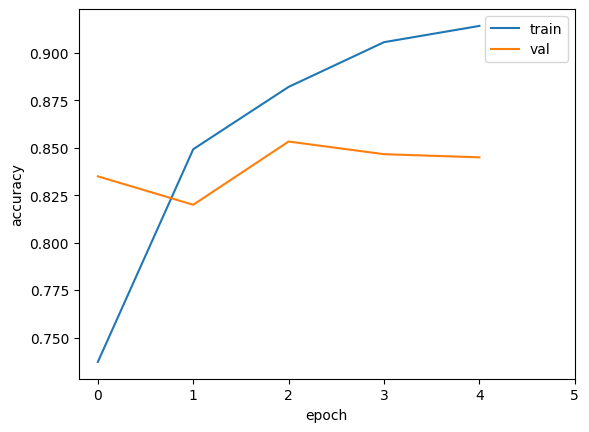

In [ ]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'val')
plt.xticks(np.arange(0,6))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

ADJUSTING LEARNING RATE

In [ ]:
def make_model(learning_rate = 0.01):
  base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(299,299,3),
    include_top=False
  )
  base_model.trainable = False

  #####################
  input = keras.Input(shape=(299,299,3))
  base = base_model(input, training = False)
  vectors = keras.layers.GlobalAveragePooling2D()(base)
  output = keras.layers.Dense(2)(vectors)
  model = keras.Model(input, output)

  ##########################
  optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

  loss = keras.losses.BinaryCrossentropy(from_logits=True)

  model.compile(optimizer=optimizer,
                loss=loss,
                metrics=['accuracy'])
  return model

In [ ]:
scores = {}

for lr in [0.01, 0.001, 0.0001, 0.1]:
  print(lr)
  model = make_model(lr)
  history = model.fit(train_ds, epochs=5, validation_data=val_ds)
  scores[lr] = history.history

  print()
  print()

0.01
Epoch 1/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 26s 431ms/step - accuracy: 0.6003 - loss: 0.7312 - val_accuracy: 0.8000 - val_loss: 0.4277
Epoch 2/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 15s 310ms/step - accuracy: 0.8428 - loss: 0.3857 - val_accuracy: 0.7900 - val_loss: 0.4110
Epoch 3/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 22s 332ms/step - accuracy: 0.8625 - loss: 0.3364 - val_accuracy: 0.8333 - val_loss: 0.3641
Epoch 4/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 15s 314ms/step - accuracy: 0.8955 - loss: 0.2611 - val_accuracy: 0.8383 - val_loss: 0.3468
Epoch 5/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 15s 309ms/step - accuracy: 0.9316 - loss: 0.2297 - val_accuracy: 0.8417 - val_loss: 0.3449


0.001
Epoch 1/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 26s 422ms/step - accuracy: 0.6013 - loss: 0.6681 - val_accuracy: 0.7667 - val_loss: 0.5663
Epoch 2/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 34s 308ms/step - accuracy: 0.7614 - loss: 0.5482 - val_accuracy: 0.7983 - val_loss: 0.5006
Epoch 3/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 313ms/step - accuracy: 0.8102 - loss: 0.4832 - val

In [ ]:
del scores[0.0001]

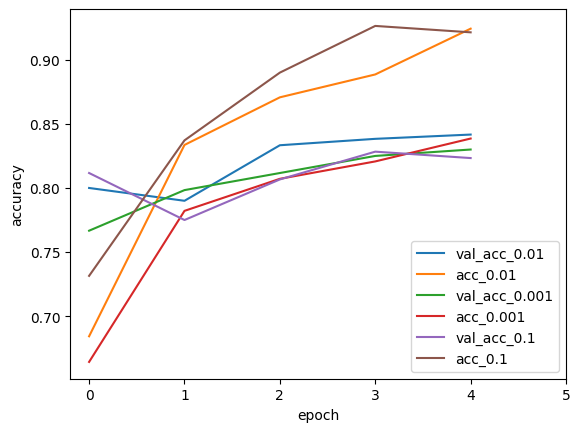

In [ ]:
for lr, history in scores.items():
  plt.plot(history['val_accuracy'], label=f'val_acc_{lr}')
  plt.plot(history['accuracy'], label=f'acc_{lr}')

plt.xticks(np.arange(0,6))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

OBSERVATION: GREEN AND RED FOR 0.001 ACCURACY AND VAL_ACC ARE NOT OVERFITTING

In [ ]:
best_lr = 0.001

CHECKPOINT

In [ ]:
checkpoint = keras.callbacks.ModelCheckpoint(
    '/content/drive/MyDrive/AI_and_python/ML-Zoomcamp/capstone1_v1_{epoch:02d}_{val_accuracy:.3f}.weights.keras',

    save_best_only = True,
    monitor = 'val_accuracy',
    mode = 'max')

In [ ]:


model = make_model(best_lr)
history = model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[checkpoint])

Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 25s 440ms/step - accuracy: 0.5940 - loss: 0.6654 - val_accuracy: 0.7617 - val_loss: 0.5612
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 34s 320ms/step - accuracy: 0.7736 - loss: 0.5294 - val_accuracy: 0.7733 - val_loss: 0.5056
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 314ms/step - accuracy: 0.7825 - loss: 0.4898 - val_accuracy: 0.8233 - val_loss: 0.4629
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 332ms/step - accuracy: 0.8324 - loss: 0.4422 - val_accuracy: 0.8217 - val_loss: 0.4406
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 16s 337ms/step - accuracy: 0.8258 - loss: 0.4262 - val_accuracy: 0.8150 - val_loss: 0.4266
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 16s 344ms/step - accuracy: 0.8551 - loss: 0.3968 - val_accuracy: 0.8317 - val_loss: 0.4134
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 15s 321ms/step - accuracy: 0.8371 - loss: 0.3973 - val_accuracy: 0.8383 - val_loss: 0.4015
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 16s 328ms/step - accuracy: 0.8698 - loss: 0.3654 - val_accu

VERSION 2 (ADDING INNER LAYERS OR MORE DENSE LAYERS)

In [ ]:
def make_model(learning_rate = 0.01, inner_size = 100):
  base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(299,299,3),
    include_top=False
  )
  base_model.trainable = False

  #####################
  input = keras.Input(shape=(299,299,3))
  base = base_model(input, training = False)
  vectors = keras.layers.GlobalAveragePooling2D()(base)
  inner = keras.layers.Dense(inner_size, activation = 'relu')(vectors)
  output = keras.layers.Dense(2)(inner)
  model = keras.Model(input, output)

  ######################
  optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

  loss = keras.losses.BinaryCrossentropy(from_logits=True)

  model.compile(optimizer=optimizer,
                loss=loss,
                metrics=['accuracy'])
  return model

In [ ]:
checkpoint = keras.callbacks.ModelCheckpoint(
    '/content/drive/MyDrive/AI_and_python/ML-Zoomcamp/capstone1_v2_{epoch:02d}_{val_accuracy:.3f}.weights.keras',

    save_best_only = True,
    monitor = 'val_accuracy',
    mode = 'max')

model = make_model(best_lr)
history = model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[checkpoint])

Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 33s 571ms/step - accuracy: 0.6667 - loss: 0.6118 - val_accuracy: 0.8133 - val_loss: 0.4234
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 28s 323ms/step - accuracy: 0.8403 - loss: 0.3748 - val_accuracy: 0.7833 - val_loss: 0.4155
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 17s 355ms/step - accuracy: 0.8619 - loss: 0.3191 - val_accuracy: 0.8517 - val_loss: 0.3397
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 342ms/step - accuracy: 0.9035 - loss: 0.2732 - val_accuracy: 0.8433 - val_loss: 0.3477
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 16s 337ms/step - accuracy: 0.9247 - loss: 0.2084 - val_accuracy: 0.8600 - val_loss: 0.3374
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 16s 325ms/step - accuracy: 0.9354 - loss: 0.1866 - val_accuracy: 0.8533 - val_loss: 0.3321
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 353ms/step - accuracy: 0.9589 - loss: 0.1576 - val_accuracy: 0.8483 - val_loss: 0.3426
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 17s 359ms/step - accuracy: 0.9681 - loss: 0.1220 - val_accu

In [ ]:
scores = {}

for size in [10, 100, 1000]:
  print(size)
  model = make_model(learning_rate = best_lr, inner_size = size)
  history = model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[checkpoint])
  scores[size] = history.history

  print()
  print()

10
Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 434ms/step - accuracy: 0.5857 - loss: 0.6919 - val_accuracy: 0.7250 - val_loss: 0.6269
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 34s 322ms/step - accuracy: 0.7313 - loss: 0.6058 - val_accuracy: 0.8133 - val_loss: 0.4952
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 340ms/step - accuracy: 0.8028 - loss: 0.4684 - val_accuracy: 0.8200 - val_loss: 0.4317
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 17s 348ms/step - accuracy: 0.8290 - loss: 0.4008 - val_accuracy: 0.8300 - val_loss: 0.3976
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 15s 329ms/step - accuracy: 0.8600 - loss: 0.3623 - val_accuracy: 0.8383 - val_loss: 0.3788
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 326ms/step - accuracy: 0.8729 - loss: 0.3356 - val_accuracy: 0.8433 - val_loss: 0.3701
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 16s 334ms/step - accuracy: 0.8891 - loss: 0.3128 - val_accuracy: 0.8333 - val_loss: 0.3634
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 327ms/step - accuracy: 0.8853 - loss: 0.3025 - val_a

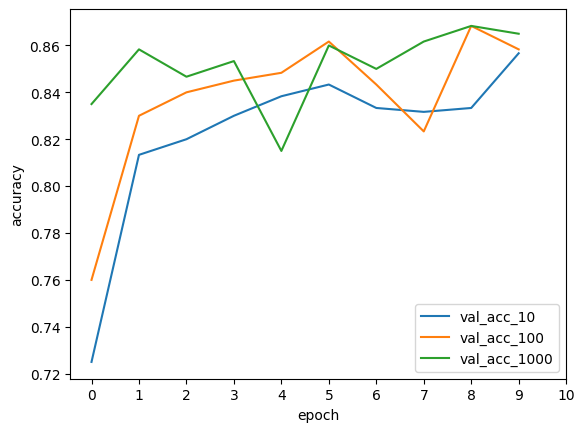

In [ ]:
for size, history in scores.items():
  plt.plot(history['val_accuracy'], label=f'val_acc_{size}')
  #plt.plot(history['accuracy'], label=f'acc_{size}')

plt.xticks(np.arange(0,11))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

In [ ]:
best_inner_size = 1000

Due to overfitting still, we shall add a dropout layer to our inner layer

VERSION 3 (DROP OUT AND REGULARIZATION)

In [ ]:
def make_model(learning_rate = 0.01, inner_size = 1000, drop_rate = 0.5):
  base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(299,299,3),
    include_top=False
  )
  base_model.trainable = False

  #####################
  input = keras.Input(shape=(299,299,3))
  base = base_model(input, training = False)
  vectors = keras.layers.GlobalAveragePooling2D()(base)
  inner = keras.layers.Dense(inner_size, activation = 'relu')(vectors)
  dropout = keras.layers.Dropout(drop_rate)(inner)
  output = keras.layers.Dense(2)(dropout)
  model = keras.Model(input, output)

  ######################
  optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

  loss = keras.losses.BinaryCrossentropy(from_logits=True)

  model.compile(optimizer=optimizer,
                loss=loss,
                metrics=['accuracy'])
  return model

In [ ]:
checkpoint = keras.callbacks.ModelCheckpoint(
    '/content/drive/MyDrive/AI_and_python/ML-Zoomcamp/capstone1_v3_{epoch:02d}_{val_accuracy:.3f}.weights.keras',

    save_best_only = True,
    monitor = 'val_accuracy',
    mode = 'max')

In [ ]:
scores = {}

for drop in [0.2, 0.5, 0.8]:
  print(drop)
  model = make_model(learning_rate = best_lr, inner_size = best_inner_size, drop_rate = drop)
  history = model.fit(train_ds, epochs=15, validation_data=val_ds, callbacks=[checkpoint])
  scores[drop] = history.history

  print()
  print()

0.2
Epoch 1/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 489ms/step - accuracy: 0.6813 - loss: 0.5867 - val_accuracy: 0.8100 - val_loss: 0.3869
Epoch 2/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 15s 320ms/step - accuracy: 0.8245 - loss: 0.3713 - val_accuracy: 0.8000 - val_loss: 0.4312
Epoch 3/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 22s 357ms/step - accuracy: 0.8920 - loss: 0.2810 - val_accuracy: 0.8333 - val_loss: 0.3434
Epoch 4/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 17s 356ms/step - accuracy: 0.9164 - loss: 0.2281 - val_accuracy: 0.8283 - val_loss: 0.3883
Epoch 5/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 16s 331ms/step - accuracy: 0.9216 - loss: 0.2092 - val_accuracy: 0.8600 - val_loss: 0.3250
Epoch 6/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 16s 334ms/step - accuracy: 0.9584 - loss: 0.1293 - val_accuracy: 0.8167 - val_loss: 0.4000
Epoch 7/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 15s 322ms/step - accuracy: 0.9683 - loss: 0.1141 - val_accuracy: 0.8517 - val_loss: 0.3366
Epoch 8/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 22s 356ms/step - accuracy: 0.9927 - loss: 0.0668 - val_

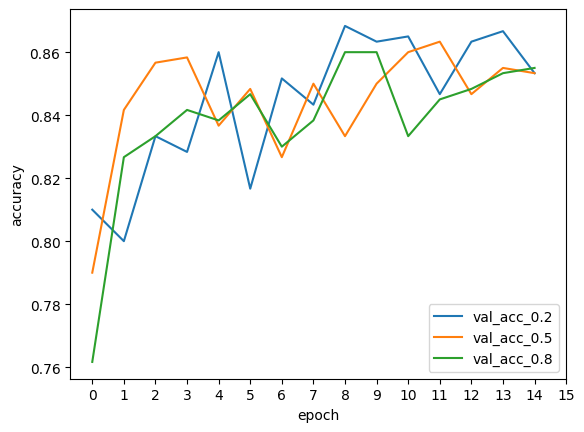

In [ ]:
for drop, history in scores.items():
  plt.plot(history['val_accuracy'], label=f'val_acc_{drop}')
  #plt.plot(history['accuracy'], label=f'acc_{size}')

plt.xticks(np.arange(0,16))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

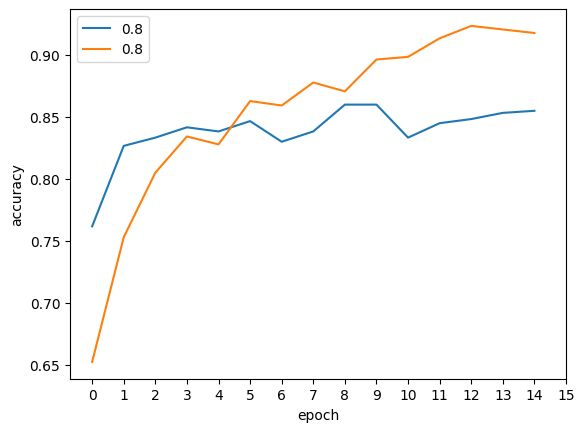

In [ ]:
hist = scores[0.8]

plt.plot(hist['val_accuracy'], label=0.8)
plt.plot(hist['accuracy'], label=0.8)

plt.xticks(np.arange(0,16))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

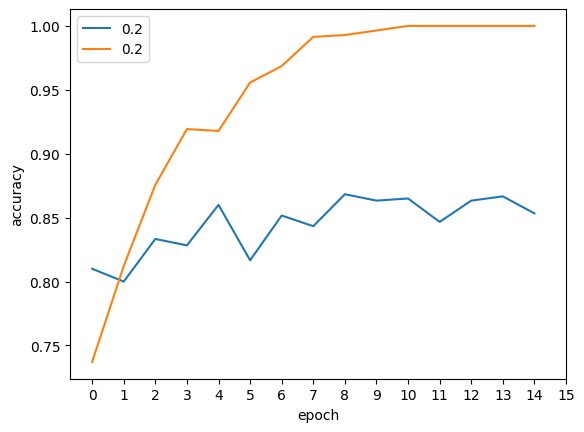

In [ ]:
hist = scores[0.2]

plt.plot(hist['val_accuracy'], label=0.2)
plt.plot(hist['accuracy'], label=0.2)

plt.xticks(np.arange(0,16))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

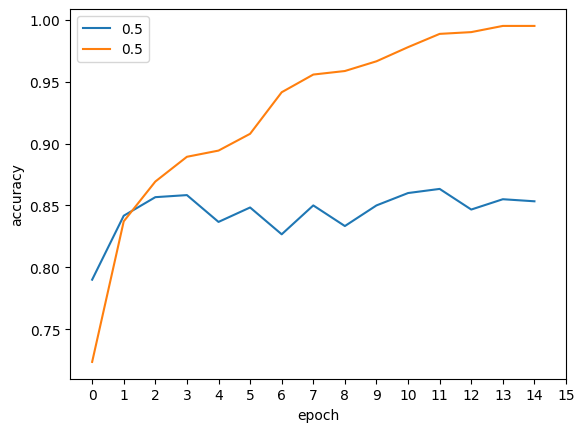

In [ ]:
hist = scores[0.5]

plt.plot(hist['val_accuracy'], label=0.5)
plt.plot(hist['accuracy'], label=0.5)

plt.xticks(np.arange(0,16))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

In [ ]:
best_drop = 0.8

In [ ]:
model = make_model(learning_rate = best_lr, inner_size = best_inner_size, drop_rate = best_drop)
history = model.fit(train_ds, epochs=15, validation_data=val_ds, callbacks=[checkpoint])

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


44/44 ━━━━━━━━━━━━━━━━━━━━ 28s 485ms/step - accuracy: 0.6002 - loss: 0.7109 - val_accuracy: 0.8183 - val_loss: 0.4325
Epoch 2/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 32s 327ms/step - accuracy: 0.7638 - loss: 0.4983 - val_accuracy: 0.8217 - val_loss: 0.4005
Epoch 3/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 16s 332ms/step - accuracy: 0.8027 - loss: 0.4283 - val_accuracy: 0.8333 - val_loss: 0.3678
Epoch 4/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 315ms/step - accuracy: 0.8254 - loss: 0.3964 - val_accuracy: 0.8333 - val_loss: 0.3551
Epoch 5/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 334ms/step - accuracy: 0.8534 - loss: 0.3409 - val_accuracy: 0.8433 - val_loss: 0.3464
Epoch 6/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 16s 338ms/step - accuracy: 0.8634 - loss: 0.3354 - val_accuracy: 0.8517 - val_loss: 0.3399
Epoch 7/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 19s 315ms/step - accuracy: 0.8768 - loss: 0.2869 - val_accuracy: 0.8417 - val_loss: 0.3301
Epoch 8/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 15s 320ms/step - accuracy: 0.8795 - loss: 0.2901 - val_accuracy: 0.851

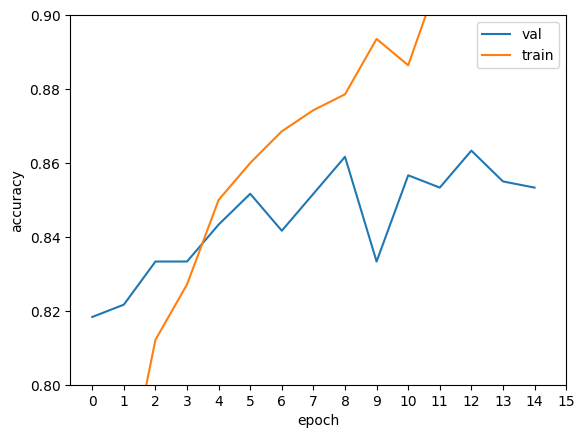

In [ ]:
plt.plot(history.history['val_accuracy'], label= 'val')
plt.plot(history.history['accuracy'], label='train')

plt.xticks(np.arange(0,16))
plt.ylim(0.8,0.9)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

*DROP RATE OF 0.8 GIVES BEST VALIDATION ACCURACY WITHOUT OVERFITTING*
 The best model was obtained at dropout version with a dropout value of 0.8

 * Model name = capstone1_V3_06_0.852.weights.keras

DATA AUGMENTATION

In [ ]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale = 1./255,
    rotation_range=50,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_ds_aug = train_gen.flow_from_directory(
    train_path,
    target_size=(299, 299),
    batch_size=32,
    shuffle=True,
)


Found 1400 images belonging to 2 classes.


In [ ]:
checkpoint = keras.callbacks.ModelCheckpoint(
    '/content/drive/MyDrive/AI_and_python/ML-Zoomcamp/capstone1_v4_Augment_{epoch:02d}_{val_accuracy:.3f}.weights.keras',

    save_best_only = True,
    monitor = 'val_accuracy',
    mode = 'max')

model = make_model(best_lr, best_inner_size, best_drop)
history = model.fit(train_ds_aug, epochs=10, validation_data=val_ds, callbacks=[checkpoint])

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


44/44 ━━━━━━━━━━━━━━━━━━━━ 54s 961ms/step - accuracy: 0.5448 - loss: 0.7044 - val_accuracy: 0.5000 - val_loss: 0.8689
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 45s 875ms/step - accuracy: 0.5852 - loss: 0.6728 - val_accuracy: 0.5000 - val_loss: 1.1466
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 78s 805ms/step - accuracy: 0.6054 - loss: 0.6665 - val_accuracy: 0.5000 - val_loss: 1.4143
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 41s 798ms/step - accuracy: 0.6069 - loss: 0.6525 - val_accuracy: 0.5000 - val_loss: 1.8945
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 41s 797ms/step - accuracy: 0.6622 - loss: 0.6346 - val_accuracy: 0.5000 - val_loss: 2.3211
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 81s 818ms/step - accuracy: 0.6677 - loss: 0.6227 - val_accuracy: 0.5000 - val_loss: 2.6286
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 41s 814ms/step - accuracy: 0.6384 - loss: 0.6396 - val_accuracy: 0.5000 - val_loss: 2.9382
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 41s 822ms/step - accuracy: 0.6160 - loss: 0.6503 - val_accuracy: 0.500

TRAIN A SMALLER MODEL: Input size 150

In [14]:
def make_model(learning_rate = 0.01, inner_size = 1000, drop_rate = 0.5):
  base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(150,150,3),
    include_top=False
  )
  base_model.trainable = False

  #####################
  input = keras.Input(shape=(150,150,3))
  base = base_model(input, training = False)
  vectors = keras.layers.GlobalAveragePooling2D()(base)
  inner = keras.layers.Dense(inner_size, activation = 'relu')(vectors)
  dropout = keras.layers.Dropout(drop_rate)(inner)
  output = keras.layers.Dense(2)(dropout)
  model = keras.Model(input, output)

  ######################
  optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

  loss = keras.losses.BinaryCrossentropy(from_logits=True)

  model.compile(optimizer=optimizer,
                loss=loss,
                metrics=['accuracy'])
  return model

In [6]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_ds = train_gen.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=32,
    shuffle=True,
)

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = val_gen.flow_from_directory(
    test_path,
    target_size=(150, 150),
    batch_size=32,
    shuffle=False,
    # class_mode='binary',
    # seed=SEED
)

Found 1400 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [7]:
checkpoint = keras.callbacks.ModelCheckpoint(
    '/content/drive/MyDrive/AI_and_python/ML-Zoomcamp/capstone1_Smallermodel_{epoch:02d}_{val_accuracy:.3f}.weights.keras',

    save_best_only = True,
    monitor = 'val_accuracy',
    mode = 'max')

In [15]:
model = make_model(best_lr, best_inner_size, best_drop)
history = model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[checkpoint])

Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 28s 345ms/step - accuracy: 0.5881 - loss: 0.9232 - val_accuracy: 0.7583 - val_loss: 0.4990
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 28s 166ms/step - accuracy: 0.7607 - loss: 0.5085 - val_accuracy: 0.8067 - val_loss: 0.4283
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - accuracy: 0.8242 - loss: 0.4122 - val_accuracy: 0.7767 - val_loss: 0.4524
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step - accuracy: 0.7771 - loss: 0.4354 - val_accuracy: 0.8033 - val_loss: 0.4136
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 186ms/step - accuracy: 0.8254 - loss: 0.3897 - val_accuracy: 0.8217 - val_loss: 0.3942
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 180ms/step - accuracy: 0.8498 - loss: 0.3343 - val_accuracy: 0.8150 - val_loss: 0.4084
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 154ms/step - accuracy: 0.8753 - loss: 0.3108 - val_accuracy: 0.8033 - val_loss: 0.4056
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step - accuracy: 0.8858 - loss: 0.2837 - val_accuracy

USING THE MODEL

In [16]:
from tensorflow import keras
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input

from tensorflow.keras.preprocessing.image import load_img

In [18]:
final_test_path = '/content/drive/MyDrive/AI_and_python/ML-Zoomcamp/data/CIFAKE/final_test'

In [17]:
model = keras.models.load_model('/content/drive/MyDrive/AI_and_python/ML-Zoomcamp/capstone1_v3_06_0.852.weights.keras')

In [19]:
final_test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

final_test_ds = val_gen.flow_from_directory(
    final_test_path,
    target_size=(299, 299),
    batch_size=32,
    shuffle=False,
    # class_mode='binary',
    # seed=SEED
)

Found 200 images belonging to 2 classes.


In [20]:
model.evaluate(final_test_ds)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 65s 8s/step - accuracy: 0.8508 - loss: 0.3836


[0.35151368379592896, 0.8650000095367432]

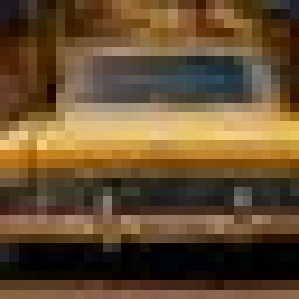

In [24]:

path = '/content/drive/MyDrive/AI_and_python/ML-Zoomcamp/data/CIFAKE/final_test/FAKE/990 (2).jpg'
load_img(path, target_size=(299,299))

In [26]:
import numpy as np

img = load_img(path, target_size=(299,299))
x = np.array(img)
X = np.array([x])
X.shape

(1, 299, 299, 3)

In [27]:
X = preprocess_input(X)
X

array([[[[-0.75686276, -0.81960785, -0.7176471 ],
         [-0.75686276, -0.81960785, -0.7176471 ],
         [-0.75686276, -0.81960785, -0.7176471 ],
         ...,
         [-0.75686276, -0.7411765 , -0.6392157 ],
         [-0.75686276, -0.7411765 , -0.6392157 ],
         [-0.75686276, -0.7411765 , -0.6392157 ]],

        [[-0.75686276, -0.81960785, -0.7176471 ],
         [-0.75686276, -0.81960785, -0.7176471 ],
         [-0.75686276, -0.81960785, -0.7176471 ],
         ...,
         [-0.75686276, -0.7411765 , -0.6392157 ],
         [-0.75686276, -0.7411765 , -0.6392157 ],
         [-0.75686276, -0.7411765 , -0.6392157 ]],

        [[-0.75686276, -0.81960785, -0.7176471 ],
         [-0.75686276, -0.81960785, -0.7176471 ],
         [-0.75686276, -0.81960785, -0.7176471 ],
         ...,
         [-0.75686276, -0.7411765 , -0.6392157 ],
         [-0.75686276, -0.7411765 , -0.6392157 ],
         [-0.75686276, -0.7411765 , -0.6392157 ]],

        ...,

        [[ 0.07450986, -0.21568626, -0

In [29]:
pred = model.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


In [31]:
pred[0]

array([ 1.3736932, -1.5569493], dtype=float32)

In [33]:
classes = ['FAKE', 'REAL']

In [34]:
dict(zip(classes, pred[0]))

{'FAKE': 1.3736932, 'REAL': -1.5569493}